In [150]:
import pandas as pd
import json
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, r2_score
import scipy

In [151]:
f = open("../results/test.json")
data = json.load(f)
mean_time_survival = 701
#data.keys()
# lists to arrays
labels = np.array(data['labels'])
predictions = np.array(data['predictions'])
stds = np.array(data['stds'])

# Compute values in real scale
labels_real = - mean_time_survival*np.log(
        np.clip(1-labels, a_min=1e-5, a_max=1))
predictions_real = - mean_time_survival*np.log(
        np.clip(1-predictions, a_min=1e-5, a_max=1))
stds_real =mean_time_survival * stds/(1 - predictions)
perfect_std_real = mean_time_survival * stds/(1 - labels)
# compute MAE and MAE between elements in real scale
mae = np.abs(labels-predictions)
mae_real = np.abs(labels_real-predictions_real)

# compute correlation coefficients:
corr_mae_stds = np.corrcoef(mae, stds)
corr_mae_stds_real = np.corrcoef(mae_real, stds_real)

# compute correlation between labels and predicttions:
corr_label_prediction = np.corrcoef(labels, predictions)
corr_label_prediction_real = np.corrcoef(labels_real, predictions_real)

# compute r2 score:
r2 = r2_score(labels, predictions)
r2_real =r2_score(labels_real, predictions_real)

# compute pearson correlation with pvalue:
pearson_corr_pvalue = pearsonr(labels, predictions)
pearson_corr_pvalue_real = pearsonr(labels_real, predictions_real)

# compute spearman correlation with pvalue:
spearman_corr_pvalue = spearmanr(labels, predictions)
spearman_corr_pvalue_real = spearmanr(labels_real, predictions_real)

In [211]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, r2_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

def compute_metrics(labels, predictions_real,predictions, thresh = 701):
    metrics = dict()
    new_thresh = 1 - np.exp(-thresh/701)
    
    new_labels = (labels>=thresh).astype(int)
    new_predictions = (predictions_real>=thresh).astype(int)
    #metrics["f1_score"] = f1_score(new_labels, new_predictions, average = None).tolist()
    metrics["accuracy"] = accuracy_score(new_labels, new_predictions)
    metrics["balanced_accuracy"] = balanced_accuracy_score(new_labels, new_predictions)
    metrics["auc"] = roc_auc_score(new_labels, predictions-new_thresh+0.5).tolist()
    precision, recall, fscore, _ = precision_recall_fscore_support(new_labels, new_predictions)
    metrics['precision'], metrics['recall'], metrics['f1_score'] = precision.tolist(), recall.tolist(), fscore.tolist()
    
    cm = confusion_matrix(new_labels, new_predictions)
    cm_df = pd.DataFrame(cm,
                        index = [0, 1], 
                        columns = [0, 1])

    # Plot the confusion Matrix
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm_df, annot=True, annot_kws={"size": 22})
    sns.set(font_scale = 1.5)
    plt.title(f'Confusion Matrix for follow-up threshold ({thresh} days)')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    #plt.savefig(os.path.join(path_results, f"confusion_matrix_{thresh}.png"))
    return metrics

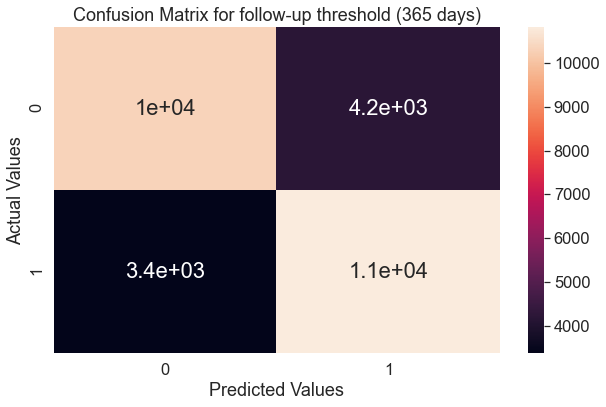

{'accuracy': 0.7367322081085784,
 'balanced_accuracy': 0.7370445255995883,
 'auc': 0.8173160981766858,
 'precision': [0.7543744531933508, 0.7206205473067447],
 'recall': [0.7114763116275872, 0.7626127395715896],
 'f1_score': [0.7322976750769666, 0.7410222176577318]}

In [212]:
compute_metrics(labels_real, predictions_real,predictions,  365)